# A simple example of using weights of observed data in Bayesian inference

In [1]:
import scipy as sp
import scipy.stats
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

### Simulating data

We will present a simple case of inference on data generated from a Poisson distribution

$$ \text{data} \sim \text{Poisson}(3.4) $$

We will generate a lot of data, to a point where doing an MCMC inference would be too costly:

In [2]:
data = pd.Series(
    sp.stats.poisson(3.4).rvs(20_000_000),
    name='value'
)

In [3]:
data.sample(5)

15242151    3
2938766     5
1925509     2
2725013     9
2673939     5
Name: value, dtype: int64

Aggregating this data, i.e, counting each unique observation value gives:

In [4]:
data_agg = data.groupby(data).count().rename('count_').reset_index()
data_agg

,value,count_
0,0,666344
1,1,2268480
2,2,3859435
3,3,4371460
4,4,3716338
5,5,2528163
6,6,1431912
7,7,696671
8,8,295527
9,9,111472


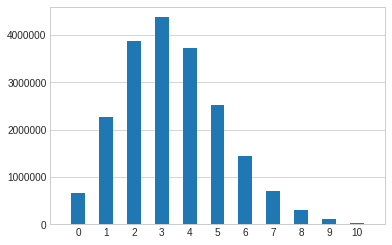

In [5]:
plt.bar(data_agg.value, data_agg.count_, width=.5)
plt.gca().set(xticks=np.linspace(0, 10, 11), xlim=(-1, 11))
plt.grid(axis='x')
None

Now, the size of the data is just 19 rows!

### Inference

We will use, of course, a Poisson likelihood. For its $\mu$ parameter, we will use a Normal prior that is centered around 3, however, we will specify that in the log-scale, in order to avoid negative values.

$$ \log(\mu) \sim \text{Normal}(\log(3), 1^2) $$

$$ \text{observed} \sim \text{Poisson}(\mu) $$

In [6]:
with pm.Model() as m1:
    log_mu = pm.Normal('log_mu', mu=np.log(3), sd=1)

    # calculated mean
    mu = pm.Deterministic('mu', pm.math.exp(log_mu))

    # this is how the inference would look like if no weights were present
    # (equivivalent of all weights equal to one):
    # obs = pm.Poisson('obs', mu=mu, observed=data_agg.value)

    # this is the inference line using weights
    # notice we are using the same likelihood function...
    likelihood = pm.Poisson.dist(mu=mu)
    # ... and using a potential on top of its log-probability function
    obs = pm.Potential(
        'obs',
        data_agg.count_.values * likelihood.logp(data_agg.value.values) 
    )

    m1.name = 'm1'
    m1.trace = pm.sample(5000, tune=10000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [log_mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 30000/30000 [00:12<00:00, 2357.14draws/s]


In [7]:
pm.summary(m1.trace, var_names=['mu'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,3.4,0.0,3.4,3.401,0.0,0.0,4108.0,4108.0,4113.0,6294.0,1.0
